In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# read in data
limonDF = pd.read_csv("Limon_2012-2021_hourlydata_munged.csv")
grandJunctionOrigDF = pd.read_csv("72476023066_GrandJunction_2002-2021_hourlydata_munged.csv")
boulderDF = pd.read_csv("72053300160_Boulder_2012-2021_hourlydata_munged.csv")
eagleDF = pd.read_csv("72467523063_Eagle_2012-2021_hourlydata_munged.csv")

In [23]:
# Look at Limon Dataframe
limonDF.head(10)

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph
0,2012-01-01T00:55:00,2012-01-01 00:55:00,15.0,11.0,0.0,84.0,843.88806,40.0,5.0,26.0
1,2012-01-01T01:55:00,2012-01-01 01:55:00,15.0,12.0,0.0,88.0,843.54944,280.0,7.0,26.0
2,2012-01-01T02:55:00,2012-01-01 02:55:00,12.0,10.0,0.0,92.0,843.88806,0.0,0.0,26.0
3,2012-01-01T03:55:00,2012-01-01 03:55:00,12.0,9.0,0.0,87.0,843.88806,0.0,0.0,26.0
4,2012-01-01T04:55:00,2012-01-01 04:55:00,14.0,9.0,0.0,80.0,844.90405,250.0,8.0,26.0
5,2012-01-01T05:55:00,2012-01-01 05:55:00,11.0,8.0,0.0,88.0,846.25854,0.0,0.0,26.0
6,2012-01-01T06:55:00,2012-01-01 06:55:00,9.0,6.0,0.0,88.0,846.93585,20.0,5.0,26.0
7,2012-01-01T07:55:00,2012-01-01 07:55:00,12.0,9.0,0.0,87.0,847.95180,0.0,0.0,26.0
8,2012-01-01T08:55:00,2012-01-01 08:55:00,24.0,17.0,0.0,75.0,848.62900,170.0,8.0,26.0
9,2012-01-01T09:55:00,2012-01-01 09:55:00,29.0,15.0,0.0,56.0,849.64496,170.0,11.0,26.0


In [24]:
# look at Boulder Dataframe
boulderDF.head(10)

# this doesn't have data hourly, its every ~20 minutes
# need to remove datapoints with times at 24 and 44 minutes

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph
0,2012-01-01T00:04:00,2012-01-01 00:04:00,28.0,9.0,0.05,43.0,843.54944,0.0,0.0,31.0
1,2012-01-01T00:24:00,2012-01-01 00:24:00,25.0,10.0,0.05,54.0,843.54944,20.0,6.0,31.0
2,2012-01-01T00:44:00,2012-01-01 00:44:00,23.0,10.0,0.05,58.0,843.54944,280.0,7.0,31.0
3,2012-01-01T01:04:00,2012-01-01 01:04:00,25.0,10.0,0.05,54.0,843.54944,0.0,0.0,31.0
4,2012-01-01T01:24:00,2012-01-01 01:24:00,23.0,10.0,0.05,58.0,843.54944,320.0,3.0,31.0
5,2012-01-01T01:44:00,2012-01-01 01:44:00,25.0,10.0,0.05,54.0,843.54944,290.0,7.0,31.0
6,2012-01-01T02:04:00,2012-01-01 02:04:00,25.0,10.0,0.05,54.0,843.54944,350.0,7.0,31.0
7,2012-01-01T02:24:00,2012-01-01 02:24:00,23.0,12.0,0.05,63.0,843.54944,310.0,3.0,31.0
8,2012-01-01T02:44:00,2012-01-01 02:44:00,23.0,12.0,0.05,63.0,843.54944,290.0,6.0,31.0
9,2012-01-01T03:04:00,2012-01-01 03:04:00,25.0,12.0,0.05,59.0,843.54944,340.0,9.0,31.0


In [25]:
# look at Eagle Dataframe
eagleDF.head(10)

# this doesn't have data hourly, its every ~20 minutes
# need to remove datapoints with times at 15 and 35 minutes

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph
0,2012-01-01T00:00:00,2012-01-01 00:00:00,12.0,5.0,0.01,73.0,811.37870,110.0,5.0,24.0
1,2012-01-01T00:55:00,2012-01-01 00:55:00,10.0,5.0,0.01,79.0,811.37870,100.0,3.0,24.0
2,2012-01-01T01:15:00,2012-01-01 01:15:00,10.0,5.0,0.01,79.0,811.37870,100.0,7.0,24.0
3,2012-01-01T01:35:00,2012-01-01 01:35:00,10.0,5.0,0.01,79.0,811.37870,80.0,6.0,24.0
4,2012-01-01T01:56:00,2012-01-01 01:56:00,10.0,5.0,0.01,79.0,811.71735,100.0,5.0,24.0
5,2012-01-01T02:15:00,2012-01-01 02:15:00,10.0,3.0,0.01,72.0,811.71735,0.0,0.0,24.0
6,2012-01-01T02:35:00,2012-01-01 02:35:00,10.0,3.0,0.01,72.0,812.05600,0.0,0.0,24.0
7,2012-01-01T02:55:00,2012-01-01 02:55:00,10.0,5.0,0.01,79.0,812.05600,0.0,0.0,24.0
8,2012-01-01T03:15:00,2012-01-01 03:15:00,9.0,3.0,0.01,78.0,812.39465,0.0,0.0,24.0
9,2012-01-01T03:36:00,2012-01-01 03:36:00,9.0,3.0,0.01,78.0,812.39465,0.0,0.0,24.0


In [27]:
# look at Grand Junction Dataframe 
grandJunctionOrigDF.head(10)
# the Grand Junction dataframe starts at an earlier date than the other 3 (2002 vs. 2012)
# adjust grandJunctionDF to only include the values we need (match up with the other datasets)

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph
0,2002-01-01T00:00:00,2002-01-01 00:00:00,31.0,29.0,0.00,92.0,859.1269,70.0,5.0,21.0
1,2002-01-01T00:09:00,2002-01-01 00:09:00,32.0,28.0,0.00,87.0,859.1269,70.0,5.0,21.0
2,2002-01-01T01:00:00,2002-01-01 01:00:00,31.0,29.0,0.00,92.0,859.1269,0.0,0.0,21.0
3,2002-01-01T01:04:00,2002-01-01 01:04:00,30.0,28.0,0.01,93.0,859.1269,230.0,3.0,21.0
4,2002-01-01T01:35:00,2002-01-01 01:35:00,30.0,28.0,0.01,93.0,859.1269,0.0,0.0,21.0
5,2002-01-01T01:45:00,2002-01-01 01:45:00,30.0,28.0,0.01,93.0,859.1269,0.0,0.0,21.0
6,2002-01-01T02:00:00,2002-01-01 02:00:00,30.0,29.0,0.01,96.0,859.1269,0.0,0.0,21.0
7,2002-01-01T02:04:00,2002-01-01 02:04:00,30.0,30.0,0.01,100.0,859.1269,70.0,5.0,21.0
8,2002-01-01T03:00:00,2002-01-01 03:00:00,30.0,30.0,0.01,100.0,859.1269,70.0,5.0,21.0
9,2002-01-01T03:13:00,2002-01-01 03:13:00,30.0,30.0,0.01,100.0,859.1269,80.0,3.0,21.0


In [81]:
# find the row number closest to the start of the other datasets
grandJunctionOrigDF.loc[128691] # this is the closest to the start of the other datasets
 
# create a new dataframe for new time period ( from the closest to the start of the other datasets to the end)
grandJunctionDF = grandJunctionOrigDF[128691:]
grandJunctionDF.index = range(len(grandJunctionDF)) # adjust the row indices to start at 0
grandJunctionDF.head(10) # this is the dataset to use in analysis

,DATE,datetime,drytemp_F,dewtemp_F,prec_inch,RH,pres_mbar,wdir,wspd_mph,wgust_mph
0,2011-12-31T23:59:00,2011-12-31 23:59:00,24.0,9.0,0.0,52.0,864.5451,100.0,10.0,14.0
1,2012-01-01T00:53:00,2012-01-01 00:53:00,24.0,9.0,0.0,52.0,864.5451,100.0,10.0,14.0
2,2012-01-01T01:53:00,2012-01-01 01:53:00,23.0,8.0,0.0,53.0,864.5451,150.0,10.0,14.0
3,2012-01-01T02:53:00,2012-01-01 02:53:00,23.0,9.0,0.0,55.0,865.5610,100.0,9.0,14.0
4,2012-01-01T03:53:00,2012-01-01 03:53:00,22.0,8.0,0.0,55.0,865.8996,0.0,0.0,14.0
5,2012-01-01T04:53:00,2012-01-01 04:53:00,19.0,9.0,0.0,65.0,865.8996,0.0,0.0,14.0
6,2012-01-01T05:00:00,2012-01-01 05:00:00,19.0,9.0,0.0,65.0,868.2701,0.0,0.0,14.0
7,2012-01-01T05:53:00,2012-01-01 05:53:00,18.0,10.0,0.0,71.0,866.5769,0.0,0.0,14.0
8,2012-01-01T06:53:00,2012-01-01 06:53:00,17.0,9.0,0.0,70.0,867.2542,130.0,3.0,14.0
9,2012-01-01T07:53:00,2012-01-01 07:53:00,19.0,8.0,0.0,62.0,868.2701,100.0,6.0,14.0


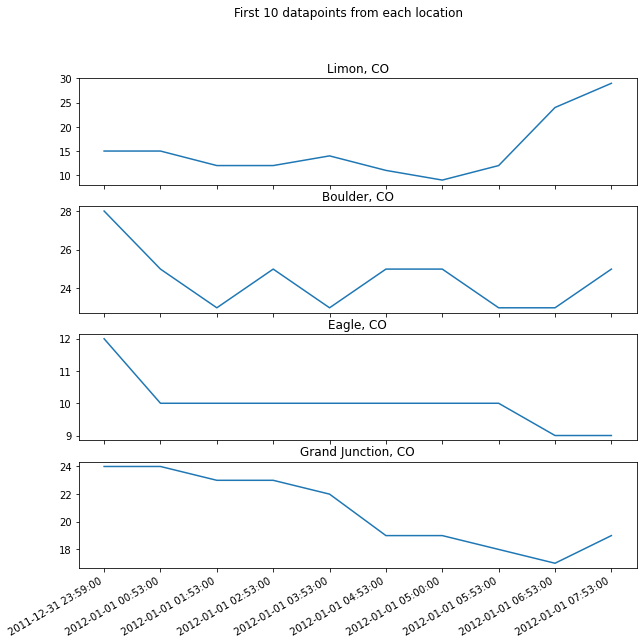

In [84]:
# graph timeseries subplots of temperature for the first 10 datapoint at all locations 
# this can be used to show that we looked at our data

fig, ax = plt.subplots(4, figsize = (10,10))
fig.suptitle("First 10 datapoints from each location")

fig.autofmt_xdate()

# subplot 1: Limon
ax[0].plot(limonDF["datetime"][0:10],limonDF["drytemp_F"][0:10])
ax[0].set_title("Limon, CO")

# subplot 2: Boulder
ax[1].plot(boulderDF["datetime"][0:10], boulderDF["drytemp_F"][0:10])
ax[1].set_title("Boulder, CO")

# subplot 3: Eagle
ax[2].plot(eagleDF["datetime"][0:10], eagleDF["drytemp_F"][0:10])
ax[2].set_title("Eagle, CO")

# subplot 4: Grand Junction
ax[3].plot(grandJunctionDF["datetime"][0:10], grandJunctionDF["drytemp_F"][0:10])
ax[3].set_title("Grand Junction, CO")
fig.savefig("Look_at_data.jpg")